1. 주파수 영역 분석
실행 내용: FFT(고속 푸리에 변환) 또는 DCT(이산 코사인 변환)를 활용하여 이미지의 주파수 성분을 추출하고, 이를 기존 RGB 스트림과 결합하는 Dual-Stream 학습 구조를 설계함.
기대 효과: 생성 모델이 이미지를 합성할 때 발생하는 고유한 격자무늬 및 픽셀 단위에서 숨겨진 고주파 노이즈를 효과적으로 탐지함.
적용 시점: 공간 정보(색상, 질감) 위주의 현재 모델 성능이 정체되어 육안 식별이 불가능한 미세 조작을 잡아내야 할 때 도입함.


2. 정밀 전처리를 통한 학습 효율 극대화
실행 내용: 페이스 랜드마크를 추출하여 얼굴 각도를 수직으로 보정하는 Face Alignment를 수행하고, 조작이 집중되는 눈·입 주변을 별도로 크롭하는 Region-Specific 전략을 적용함.
기대 효과: 입력 데이터의 기하학적 편차를 줄여 학습 효율을 높이고, 핵심 부위의 미세한 왜곡에 대한 모델의 집중도를 향상시켜 성능을 즉각적으로 개선함.
적용 시점: 본격적인 데이터 증강 전, 모델이 가장 표준화된 특징을 학습할 수 있도록 프로젝트 전 과정에 걸쳐 상시 적용함.

3. 일반화 성능 확보
실행 내용: 학습 과정에서 얼굴의 특정 핵심 부위(눈, 입 등)를 무작위로 마스킹하여 학습시키는 Face-Cutout 기법을 도입함.
기대 효과: 모델이 특정 부위에만 의존하지 않고 피부 결이나 머리카락 경계선 등 얼굴 전체의 다양한 흔적을 찾도록 강제하여 일반화 성능을 확보함.
적용 시점: 학습 데이터에 모델이 Overfitting하여 실제 새로운 영상에 대한 판별력이 떨어지는 시기에 적용이 매우 효과적임.
--> 이 내용은 현재 모델 성능이 너무 좋게 나와서, 과적합이 좀 의심되다보니 적용해보면 좋을 것 같아 추가해봤습니다.

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

path = '/content/drive/MyDrive/selected_data/images'


In [ ]:
import os
import json
import random
import cv2
import torch
import timm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

def set_seed(seed=123):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"✅ 모든 시드가 {seed}로 고정되었습니다.")

set_seed(123)

✅ 모든 시드가 123로 고정되었습니다.


In [ ]:
import os
import json
import pandas as pd
import shutil
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

BASE_DIR = "/content/drive/MyDrive/selected_data"
IMG_DIR = os.path.join(BASE_DIR, "images")
DRIVE_META_DIR = os.path.join(BASE_DIR, "meta")
LOCAL_META_DIR = "/content/tmp_meta"

if not os.path.exists(LOCAL_META_DIR):
    print("🚚 JSON 메타데이터를 로컬로 복사 중... (잠시만 기다리세요)")
    os.makedirs(LOCAL_META_DIR, exist_ok=True)
    !cp -r "{DRIVE_META_DIR}"/* "{LOCAL_META_DIR}"/
    print("✅ 로컬 복사 완료!")

def load_json_task(fname):
    """단일 JSON 파일을 읽어 데이터를 반환하는 함수"""
    base_name = os.path.splitext(fname)[0]
    json_path = os.path.join(LOCAL_META_DIR, base_name + ".json")

    if os.path.exists(json_path):
        try:
            with open(json_path, 'r') as f:
                meta = json.load(f)
                label = 1 if meta.get('label', 'REAL').upper() == 'FAKE' else 0
                video_name = meta.get('video', 'unknown')
                original_name = meta.get('original')
                group_id = original_name if (label == 1 and original_name) else video_name

                return {
                    'file_name': fname,
                    'label': label,
                    'group_id': group_id,
                    'video_id': video_name
                }
        except:
            return None
    return None

def build_master_fast(img_dir):
    valid_exts = ('.jpg', '.jpeg', '.png')
    img_files = [f for f in os.listdir(img_dir) if f.lower().endswith(valid_exts)]

    print(f"🔎 처리할 이미지: {len(img_files)}개")

    data = []
    with ThreadPoolExecutor(max_workers=8) as executor:
        results = list(tqdm(executor.map(load_json_task, img_files), total=len(img_files), desc="Fast Matching"))

    data = [r for r in results if r is not None]

    df = pd.DataFrame(data)
    print(f"✨ 명단 복구 완료: 총 {len(df)}개 샘플")
    return df

master_df = build_master_fast(IMG_DIR)

if not master_df.empty:
    from sklearn.model_selection import train_test_split

    unique_groups = master_df['group_id'].unique()
    train_groups, val_groups = train_test_split(unique_groups, test_size=0.2, random_state=123)

    train_df = master_df[master_df['group_id'].isin(train_groups)].reset_index(drop=True)
    val_df = master_df[master_df['group_id'].isin(val_groups)].reset_index(drop=True)

    print(f"📊 최종 분할 -> 학습: {len(train_df)}장, 검증: {len(val_df)}장")
else:
    print("⛔ master_df가 비어있어 다음 단계를 진행할 수 없습니다.")

🚚 JSON 메타데이터를 로컬로 복사 중... (잠시만 기다리세요)
✅ 로컬 복사 완료!
🔎 처리할 이미지: 5200개


Fast Matching: 100%|██████████| 5200/5200 [00:00<00:00, 7679.41it/s]


✨ 명단 복구 완료: 총 5200개 샘플
📊 최종 분할 -> 학습: 4108장, 검증: 1092장


In [ ]:
# 1. 실제 폴더 내 이미지 파일 리스트 (확장자 필터링)
valid_exts = ('.jpg', '.jpeg', '.png')
actual_img_files = set([f for f in os.listdir(IMG_DIR) if f.lower().endswith(valid_exts)])

# 2. 결과물(df)에 포함된 이미지 파일 리스트
matched_img_files = set(master_df['file_name'].tolist())

# 3. 차집합 구하기 (폴더에는 있지만 JSON이 없어서 누락된 파일들)
missing_files = list(actual_img_files - matched_img_files)

print(f"📁 전체 이미지 수: {len(actual_img_files)}개")
print(f"✅ 매칭된 이미지 수: {len(matched_img_files)}개")
print(f"❌ 누락된 이미지 수: {len(missing_files)}개")

if missing_files:
    print(f"\n⚠️ 누락 예시(최대 5개): {missing_files[:5]}")
    print(f"👉 이 이미지들은 '{LOCAL_META_DIR}' 폴더 내에 대응하는 .json 파일이 없어서 제외되었습니다.")

📁 전체 이미지 수: 5200개
✅ 매칭된 이미지 수: 5200개
❌ 누락된 이미지 수: 0개


In [ ]:
LOCAL_IMG_PATH = "/content/local_images"
if not os.path.exists(LOCAL_IMG_PATH):
    print("🚚 이미지 파일을 로컬로 복사 중... (학습 속도를 위해 필수!)")
    os.makedirs(LOCAL_IMG_PATH, exist_ok=True)
    !cp -r "{IMG_DIR}"/* "{LOCAL_IMG_PATH}"/
    print("✅ 이미지 복사 완료!")

🚚 이미지 파일을 로컬로 복사 중... (학습 속도를 위해 필수!)
✅ 이미지 복사 완료!


In [ ]:
print("📊 데이터 라벨 분포:")
print(master_df['label'].value_counts())


📊 데이터 라벨 분포:
label
1    4199
0    1001
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

unique_groups = master_df['group_id'].unique()
train_groups, val_groups = train_test_split(unique_groups, test_size=0.2, random_state=123)

train_df = master_df[master_df['group_id'].isin(train_groups)].reset_index(drop=True)
val_df = master_df[master_df['group_id'].isin(val_groups)].reset_index(drop=True)

print(f"\n✅ 분할 완료 | 학습: {len(train_df)}장, 검증: {len(val_df)}장")


✅ 분할 완료 | 학습: 4108장, 검증: 1092장


## 전처리만 적용 (face alignment & 과적합 방지) _ efficient b0

In [ ]:
!pip install -U mediapipe albumentations


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 122.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 13.8 MB/s eta 0:00:00
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0


In [ ]:
!wget -q -O face_landmarker.task https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task

In [ ]:
import cv2
import numpy as np
import torch
import os
import timm
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from PIL import Image
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
import albumentations as A
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# --- 1. 최신 Tasks API 기반 전처리기 ---
class AdvancedPreprocessor:
    def __init__(self, image_size=224, model_path='face_landmarker.task'):
        self.image_size = image_size
        base_options = python.BaseOptions(model_asset_path=model_path)
        options = vision.FaceLandmarkerOptions(
            base_options=base_options,
            output_face_blendshapes=False,
            num_faces=1
        )
        self.detector = vision.FaceLandmarker.create_from_options(options)

        # [수정] 최신 Albumentations 2.0.8 문법: 불필요한 인자 제거
        self.train_aug = A.Compose([
            A.HorizontalFlip(p=0.5),
            # fill_value 대신 p만 남겨도 기본값(0)으로 작동합니다.
            A.CoarseDropout(p=0.5),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])

        self.val_aug = A.Compose([
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])

    def align_face(self, image):
        try:
            rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb_img)
            detection_result = self.detector.detect(mp_image)

            if not detection_result or not detection_result.face_landmarks:
                return cv2.resize(image, (self.image_size, self.image_size))

            landmarks = detection_result.face_landmarks[0]
            h, w, _ = image.shape
            left_eye = np.array([landmarks[33].x * w, landmarks[33].y * h])
            right_eye = np.array([landmarks[263].x * w, landmarks[263].y * h])

            angle = np.degrees(np.arctan2(right_eye[1]-left_eye[1], right_eye[0]-left_eye[0]))
            M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
            aligned_img = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC)
            return cv2.resize(aligned_img, (self.image_size, self.image_size))
        except:
            return cv2.resize(image, (self.image_size, self.image_size))

# --- 2. Dataset 및 Training 함수 (구조 동일) ---
class DeepfakeDataset(Dataset):
    def __init__(self, df, img_dir, preprocessor, is_train=True):
        self.df = df
        self.img_dir = img_dir
        self.preprocessor = preprocessor
        self.is_train = is_train

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['file_name'])
        image = cv2.imread(img_path)
        if image is None:
            image = np.zeros((self.preprocessor.image_size, self.preprocessor.image_size, 3), dtype=np.uint8)

        aligned_face = self.preprocessor.align_face(image)

        if self.is_train:
            img_tensor = self.preprocessor.train_aug(image=aligned_face)["image"]
        else:
            img_tensor = self.preprocessor.val_aug(image=aligned_face)["image"]

        return img_tensor, torch.tensor(row['label'], dtype=torch.float32)

def train_with_visual_advanced(train_df, val_df, model_name='efficientnet_b0', epochs=5, batch_size=32):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = timm.create_model(model_name, pretrained=True, num_classes=1).to(device)

    # B0 기본 해상도 적용 (224)
    img_size = 224
    preprocessor = AdvancedPreprocessor(image_size=img_size)

    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = torch.nn.BCEWithLogitsLoss()
    scaler = torch.amp.GradScaler('cuda')
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

    # history에 val_acc 추가 (plot_learning_curves 함수와 연결)
    history = {'train_loss': [], 'val_auc': [], 'val_acc': [], 'val_f1': []}
    best_val_auc = 0.0
    SAVE_PATH = f"/content/drive/MyDrive/deepfake_model/best_{model_name}_advanced_2.pth"

    train_loader = DataLoader(
        DeepfakeDataset(train_df, LOCAL_IMG_PATH, preprocessor, is_train=True),
        batch_size=batch_size,
        shuffle=True,
        num_workers=0, # 0으로 고정!
        pin_memory=True
    )
    val_loader = DataLoader(
        DeepfakeDataset(val_df, LOCAL_IMG_PATH, preprocessor, is_train=False),
        batch_size=batch_size,
        shuffle=False,
        num_workers=0
    )

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
            imgs, labels = imgs.to(device), labels.to(device).unsqueeze(1)
            optimizer.zero_grad()
            with torch.amp.autocast('cuda'):
                loss = criterion(model(imgs), labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()

        model.eval()
        all_labels, all_probs = [], []
        with torch.no_grad():
            for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
                with torch.amp.autocast('cuda'):
                    outputs = model(imgs.to(device))
                all_probs.extend(torch.sigmoid(outputs).cpu().numpy())
                all_labels.extend(labels.numpy())

        # 성능 지표 계산
        all_probs = np.array(all_probs).flatten()
        all_labels = np.array(all_labels).flatten()
        all_preds = (all_probs > 0.5).astype(int)

        auc = roc_auc_score(all_labels, all_probs)
        acc = accuracy_score(all_labels, all_preds) # 시각화용 정확도 추가
        f1 = f1_score(all_labels, all_preds)

        history['train_loss'].append(total_loss / len(train_loader))
        history['val_auc'].append(auc)
        history['val_acc'].append(acc) # history 기록
        history['val_f1'].append(f1)
        scheduler.step(auc)

        print(f"✨ Epoch {epoch+1} - Loss: {history['train_loss'][-1]:.4f} | AUC: {auc:.4f} | Acc: {acc:.4f} | F1: {f1:.4f}")

        if auc > best_val_auc:
            best_val_auc = auc
            torch.save(model.state_dict(), SAVE_PATH)
            print(f"🔥 최고 성능 갱신 ({auc:.4f})! 모델 저장 완료.")

    return model, history

In [ ]:
trained_model, history = train_with_visual_advanced(train_df, val_df)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Epoch 1/5 [Val]: 100%|██████████| 35/35 [00:21<00:00,  1.65it/s]


✨ Epoch 1 - Loss: 0.8611 | AUC: 0.6338 | Acc: 0.7353 | F1: 0.8374
🔥 최고 성능 갱신 (0.6338)! 모델 저장 완료.


Epoch 2/5 [Val]: 100%|██████████| 35/35 [00:17<00:00,  1.98it/s]


✨ Epoch 2 - Loss: 0.4197 | AUC: 0.6796 | Acc: 0.7582 | F1: 0.8493
🔥 최고 성능 갱신 (0.6796)! 모델 저장 완료.


Epoch 3/5 [Val]: 100%|██████████| 35/35 [00:17<00:00,  1.98it/s]


✨ Epoch 3 - Loss: 0.2718 | AUC: 0.6515 | Acc: 0.7125 | F1: 0.8191


Epoch 4/5 [Val]: 100%|██████████| 35/35 [00:17<00:00,  1.97it/s]


✨ Epoch 4 - Loss: 0.2274 | AUC: 0.6501 | Acc: 0.7299 | F1: 0.8317


Epoch 5/5 [Val]: 100%|██████████| 35/35 [00:17<00:00,  1.97it/s]

✨ Epoch 5 - Loss: 0.1807 | AUC: 0.6428 | Acc: 0.7390 | F1: 0.8346


In [ ]:
def plot_learning_curves(history):
    plt.figure(figsize=(12, 5))

    # Loss 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss', color='red', marker='o')
    plt.title('Loss Trend')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)

    # Accuracy, AUC, F1 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history['val_auc'], label='Val AUC', color='blue', marker='s')
    plt.plot(history['val_acc'], label='Val Acc', color='green', marker='^')
    plt.plot(history['val_f1'], label='Val F1', color='orange', marker='d') # F1 곡선 추가
    plt.title('Performance Metrics')
    plt.xlabel('Epoch'); plt.ylabel('Score'); plt.legend(); plt.grid(True)

    plt.tight_layout()
    plt.show()

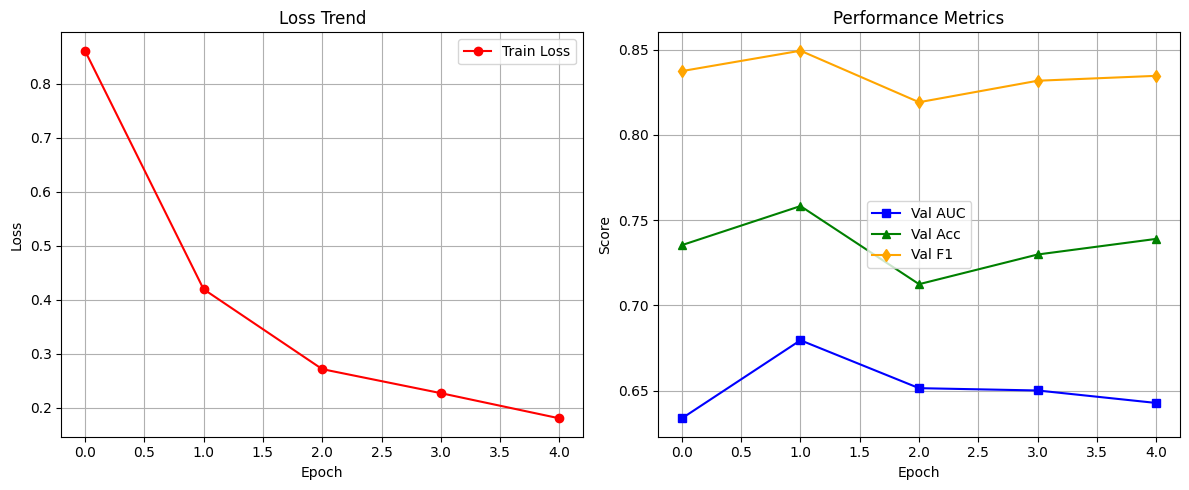

In [ ]:
plot_learning_curves(history)

## 전처리만 적용 (face alignment & 과적합 방지) _ efficient b4

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tqdm
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# 1. 경로 설정
RAW_IMG_DIR = LOCAL_IMG_PATH  # 원본 폴더
SAVE_IMG_DIR = "/content/aligned_images_b4_2" # 정렬된 이미지 저장 폴더
os.makedirs(SAVE_IMG_DIR, exist_ok=True)

# 2. MediaPipe Detector 설정
# face_landmarker.task 파일이 현재 경로에 있어야 합니다.
base_options = python.BaseOptions(model_asset_path='face_landmarker.task')
options = vision.FaceLandmarkerOptions(base_options=base_options, num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

def run_offline_preprocessing(df, target_size=380):
    print("🚀 오프라인 전처리를 시작합니다. 얼굴을 찾고 정렬합니다...")
    for idx, row in tqdm.tqdm(df.iterrows(), total=len(df)):
        file_name = row['file_name']
        save_path = os.path.join(SAVE_IMG_DIR, file_name)
        if os.path.exists(save_path): continue # 이미 있으면 패스

        img_path = os.path.join(RAW_IMG_DIR, file_name)
        image = cv2.imread(img_path)
        if image is None: continue

        try:
            rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb_img)
            res = detector.detect(mp_image)

            if res.face_landmarks:
                landmarks = res.face_landmarks[0]
                h, w, _ = image.shape
                # 눈 위치 기반 수평 정렬
                left = np.array([landmarks[33].x * w, landmarks[33].y * h])
                right = np.array([landmarks[263].x * w, landmarks[263].y * h])
                angle = np.degrees(np.arctan2(right[1]-left[1], right[0]-left[0]))
                M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
                image = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC)

            image = cv2.resize(image, (target_size, target_size))
            cv2.imwrite(save_path, image)
        except:
            image = cv2.resize(image, (target_size, target_size))
            cv2.imwrite(save_path, image)

# 실행 (Train/Val 전체 데이터)
all_df = pd.concat([train_df, val_df])
run_offline_preprocessing(all_df, target_size=380)

🚀 오프라인 전처리를 시작합니다. 얼굴을 찾고 정렬합니다...


100%|██████████| 5200/5200 [01:23<00:00, 62.30it/s]


model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

Val: 100%|██████████| 137/137 [00:05<00:00, 23.29it/s]


✨ Epoch 1 - Loss: 0.4612 | AUC: 0.6638 | Acc: 0.7088 | F1: 0.8143 | LR: 0.000100
🔥 모델 저장 완료 (AUC: 0.6638)


Val: 100%|██████████| 137/137 [00:05<00:00, 24.43it/s]


✨ Epoch 2 - Loss: 0.3393 | AUC: 0.7232 | Acc: 0.7747 | F1: 0.8626 | LR: 0.000100
🔥 모델 저장 완료 (AUC: 0.7232)


Val: 100%|██████████| 137/137 [00:05<00:00, 24.11it/s]


✨ Epoch 3 - Loss: 0.2737 | AUC: 0.7251 | Acc: 0.7582 | F1: 0.8483 | LR: 0.000100
🔥 모델 저장 완료 (AUC: 0.7251)


Val: 100%|██████████| 137/137 [00:05<00:00, 24.60it/s]


✨ Epoch 4 - Loss: 0.2266 | AUC: 0.7144 | Acc: 0.7610 | F1: 0.8499 | LR: 0.000100


Val: 100%|██████████| 137/137 [00:05<00:00, 24.24it/s]


✨ Epoch 5 - Loss: 0.1908 | AUC: 0.7612 | Acc: 0.7546 | F1: 0.8416 | LR: 0.000100
🔥 모델 저장 완료 (AUC: 0.7612)


Val: 100%|██████████| 137/137 [00:05<00:00, 24.51it/s]


✨ Epoch 6 - Loss: 0.1672 | AUC: 0.7263 | Acc: 0.8022 | F1: 0.8793 | LR: 0.000100


Val: 100%|██████████| 137/137 [00:05<00:00, 24.31it/s]


✨ Epoch 7 - Loss: 0.1363 | AUC: 0.7611 | Acc: 0.8059 | F1: 0.8801 | LR: 0.000100


Val: 100%|██████████| 137/137 [00:05<00:00, 24.56it/s]


✨ Epoch 8 - Loss: 0.1156 | AUC: 0.7648 | Acc: 0.7830 | F1: 0.8665 | LR: 0.000100
🔥 모델 저장 완료 (AUC: 0.7648)


Val: 100%|██████████| 137/137 [00:05<00:00, 24.02it/s]


✨ Epoch 9 - Loss: 0.1102 | AUC: 0.7782 | Acc: 0.7995 | F1: 0.8773 | LR: 0.000100
🔥 모델 저장 완료 (AUC: 0.7782)


Val: 100%|██████████| 137/137 [00:05<00:00, 24.62it/s]


✨ Epoch 10 - Loss: 0.0954 | AUC: 0.8147 | Acc: 0.7647 | F1: 0.8466 | LR: 0.000100
🔥 모델 저장 완료 (AUC: 0.8147)


Val: 100%|██████████| 137/137 [00:05<00:00, 23.97it/s]


✨ Epoch 11 - Loss: 0.0931 | AUC: 0.7698 | Acc: 0.7811 | F1: 0.8635 | LR: 0.000100


Val: 100%|██████████| 137/137 [00:05<00:00, 24.32it/s]


✨ Epoch 12 - Loss: 0.0809 | AUC: 0.8098 | Acc: 0.7793 | F1: 0.8603 | LR: 0.000100


Val: 100%|██████████| 137/137 [00:05<00:00, 23.96it/s]


✨ Epoch 13 - Loss: 0.0798 | AUC: 0.8174 | Acc: 0.8159 | F1: 0.8868 | LR: 0.000100
🔥 모델 저장 완료 (AUC: 0.8174)


Val: 100%|██████████| 137/137 [00:05<00:00, 24.25it/s]


✨ Epoch 14 - Loss: 0.0681 | AUC: 0.8101 | Acc: 0.7821 | F1: 0.8621 | LR: 0.000100


Val: 100%|██████████| 137/137 [00:05<00:00, 24.28it/s]


✨ Epoch 15 - Loss: 0.0687 | AUC: 0.7921 | Acc: 0.7839 | F1: 0.8639 | LR: 0.000100


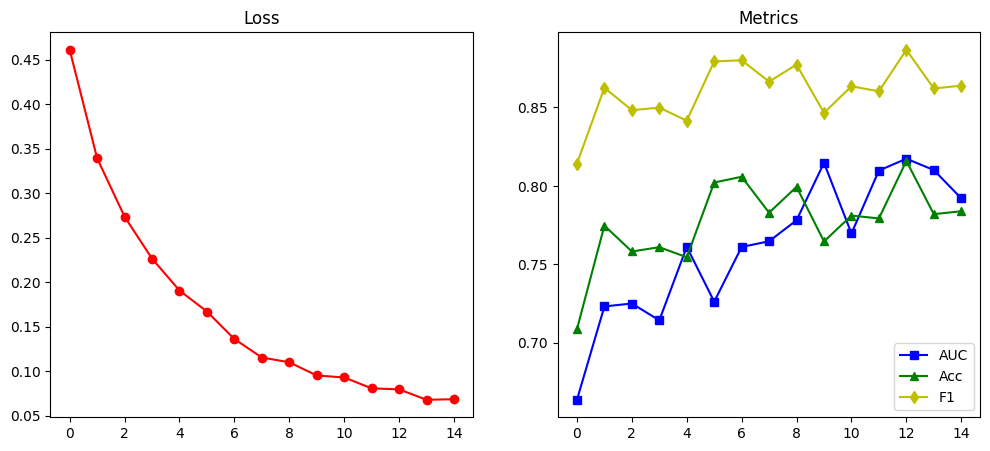

In [ ]:
import torch
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

# 1. Dataset: 저장된 '정렬 이미지'를 바로 읽어옴 (매우 빠름)
class OfflineDeepfakeDataset(Dataset):
    def __init__(self, df, aligned_dir, transform=None):
        self.df = df
        self.aligned_dir = aligned_dir
        self.transform = transform

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.aligned_dir, row['file_name'])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)['image']
        return image, torch.tensor(row['label'], dtype=torch.float32)

# 2. 강력한 데이터 증강 (B4 최적화)
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, p=0.5),
    A.CoarseDropout(p=0.5), # Face-Cutout (과적합 방지)
    A.Normalize(),
    ToTensorV2()
])
val_transform = A.Compose([A.Normalize(), ToTensorV2()])

# 3. 학습 함수
def train_super_b4(train_df, val_df, epochs=10, batch_size=8):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = timm.create_model('efficientnet_b4', pretrained=True, num_classes=1).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)
    criterion = torch.nn.BCEWithLogitsLoss()
    scaler = torch.amp.GradScaler('cuda')

    train_loader = DataLoader(OfflineDeepfakeDataset(train_df, SAVE_IMG_DIR, train_transform),
                              batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(OfflineDeepfakeDataset(val_df, SAVE_IMG_DIR, val_transform),
                            batch_size=batch_size, shuffle=False)

    history = {'train_loss': [], 'val_auc': [], 'val_acc': [], 'val_f1': []}
    best_auc = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for imgs, labels in tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
            imgs, labels = imgs.to(device), labels.to(device).unsqueeze(1)
            optimizer.zero_grad()
            with torch.amp.autocast('cuda'):
                loss = criterion(model(imgs), labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()

        # Validation
        model.eval()
        probs, targets = [], []
        with torch.no_grad():
            for imgs, labels in tqdm.tqdm(val_loader, desc=f"Val"):
                outputs = model(imgs.to(device))
                probs.extend(torch.sigmoid(outputs).cpu().numpy())
                targets.extend(labels.numpy())

        probs, targets = np.array(probs).flatten(), np.array(targets).flatten()
        preds = (probs > 0.5).astype(int)

        # 지표 계산
        auc = roc_auc_score(targets, probs)
        acc = accuracy_score(targets, preds)
        f1 = f1_score(targets, preds)
        avg_loss = total_loss / len(train_loader)

        history['train_loss'].append(avg_loss)
        history['val_auc'].append(auc)
        history['val_acc'].append(acc)
        history['val_f1'].append(f1)

        scheduler.step(auc)

        print(f"✨ Epoch {epoch+1} - Loss: {avg_loss:.4f} | AUC: {auc:.4f} | Acc: {acc:.4f} | F1: {f1:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")

        if auc > best_auc:
            best_auc = auc
            torch.save(model.state_dict(), "best_b4_advanced.pth")
            print(f"🔥 모델 저장 완료 (AUC: {auc:.4f})")

    return history

# 4. 시각화 함수
def plot_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1,2,1); plt.plot(history['train_loss'], 'r-o'); plt.title('Loss')
    plt.subplot(1,2,2);
    plt.plot(history['val_auc'], 'b-s', label='AUC')
    plt.plot(history['val_acc'], 'g-^', label='Acc')
    plt.plot(history['val_f1'], 'y-d', label='F1')
    plt.legend(); plt.title('Metrics'); plt.show()

# 실행!
history_b4 = train_super_b4(train_df, val_df, epochs=15, batch_size=8)
plot_history(history_b4)

## b4 + 주파수 + 증강 강화 + early stopping

In [ ]:
import torch
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import tqdm

# 1. Dual-Stream 데이터셋 정의 (FFT 포함)
class DualStreamDataset(Dataset):
    def __init__(self, df, aligned_dir, transform=None):
        self.df = df
        self.aligned_dir = aligned_dir
        self.transform = transform

    def get_fft(self, img):
        """이미지에서 주파수 흔적 추출"""
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        f = np.fft.fft2(gray)
        fshift = np.fft.fftshift(f)
        mag = 20 * np.log(np.abs(fshift) + 1)
        mag = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
        return cv2.merge([mag, mag, mag]).astype(np.uint8)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.aligned_dir, row['file_name'])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        fft_image = self.get_fft(image)

        if self.transform:
            augmented = self.transform(image=image, fft_image=fft_image)
            image, fft_image = augmented['image'], augmented['fft_image']

        return image, fft_image, torch.tensor(row['label'], dtype=torch.float32)

    def __len__(self): return len(self.df)


In [ ]:
# 2. Dual-Stream 모델 정의 (B4 + B0 결합)
class DualStreamB4(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.rgb_stream = timm.create_model('efficientnet_b4', pretrained=True, num_classes=0, global_pool='avg')
        self.fft_stream = timm.create_model('efficientnet_b0', pretrained=True, num_classes=0, global_pool='avg')
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(1792 + 1280, 512), torch.nn.ReLU(),
            torch.nn.Dropout(0.3), torch.nn.Linear(512, 1)
        )

    def forward(self, x_rgb, x_fft):
        feat_rgb = self.rgb_stream(x_rgb)
        feat_fft = self.fft_stream(x_fft)
        return self.classifier(torch.cat((feat_rgb, feat_fft), dim=1))

# 3. 강화된 데이터 증강 및 학습 함수
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=20, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ColorJitter(p=0.5),
    A.CoarseDropout(max_holes=8, max_height=40, max_width=40, p=0.5),
    A.Normalize(), ToTensorV2()
], additional_targets={'fft_image': 'image'})

val_transform = A.Compose([A.Normalize(), ToTensorV2()], additional_targets={'fft_image': 'image'})


/tmp/ipython-input-2398806340.py:23: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=40, max_width=40, p=0.5),


In [ ]:
def train_super_b4_dual(train_df, val_df, epochs=30, batch_size=4):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = DualStreamB4().to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)
    criterion = torch.nn.BCEWithLogitsLoss()
    scaler = torch.amp.GradScaler('cuda')

    train_loader = DataLoader(DualStreamDataset(train_df, SAVE_IMG_DIR, train_transform),
                              batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(DualStreamDataset(val_df, SAVE_IMG_DIR, val_transform),
                            batch_size=batch_size, shuffle=False)

    history = {'train_loss': [], 'val_auc': [], 'val_acc': [], 'val_f1': []}
    best_auc, counter, patience = 0, 0, 5

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for imgs, ffts, labels in tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
            imgs, ffts, labels = imgs.to(device), ffts.to(device), labels.to(device).unsqueeze(1)
            optimizer.zero_grad()
            with torch.amp.autocast('cuda'):
                loss = criterion(model(imgs, ffts), labels)
            scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
            total_loss += loss.item()

        model.eval()
        probs, targets = [], []
        with torch.no_grad():
            for imgs, ffts, labels in tqdm.tqdm(val_loader, desc="Val"):
                out = model(imgs.to(device), ffts.to(device))
                probs.extend(torch.sigmoid(out).cpu().numpy()); targets.extend(labels.numpy())

        probs, targets = np.array(probs).flatten(), np.array(targets).flatten()
        auc = roc_auc_score(targets, probs)
        acc = accuracy_score(targets, (probs > 0.5).astype(int))
        f1 = f1_score(targets, (probs > 0.5).astype(int))
        avg_loss = total_loss / len(train_loader)

        history['train_loss'].append(avg_loss)
        history['val_auc'].append(auc); history['val_acc'].append(acc); history['val_f1'].append(f1)
        scheduler.step(auc)

        # 요청하신 출력 양식 적용
        print(f"✨ Epoch {epoch+1} - Loss: {avg_loss:.4f} | AUC: {auc:.4f} | Acc: {acc:.4f} | F1: {f1:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")

        if auc > best_auc:
            best_auc = auc; torch.save(model.state_dict(), "best_dual_b4.pth")
            print(f"🔥 모델 저장 완료 (AUC: {auc:.4f})"); counter = 0
        else:
            counter += 1
            if counter >= patience: print("🛑 Early Stopping!"); break

    return history

# 4. 시각화 함수
def plot_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1,2,1); plt.plot(history['train_loss'], 'r-o'); plt.title('Loss Trend')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(history['val_auc'], 'b-s', label='Val AUC')
    plt.plot(history['val_acc'], 'g-^', label='Val Acc')
    plt.plot(history['val_f1'], 'y-d', label='Val F1')
    plt.title('Performance Metrics'); plt.xlabel('Epoch'); plt.ylabel('Score')
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


Val: 100%|██████████| 273/273 [00:19<00:00, 14.26it/s]


✨ Epoch 1 - Loss: 0.4399 | AUC: 0.6944 | Acc: 0.7747 | F1: 0.8657 | LR: 0.000100
🔥 모델 저장 완료 (AUC: 0.6944)


Val: 100%|██████████| 273/273 [00:19<00:00, 14.33it/s]


✨ Epoch 2 - Loss: 0.3409 | AUC: 0.7150 | Acc: 0.7701 | F1: 0.8558 | LR: 0.000100
🔥 모델 저장 완료 (AUC: 0.7150)


Val: 100%|██████████| 273/273 [00:19<00:00, 14.35it/s]


✨ Epoch 3 - Loss: 0.2690 | AUC: 0.7590 | Acc: 0.7637 | F1: 0.8475 | LR: 0.000100
🔥 모델 저장 완료 (AUC: 0.7590)


Val: 100%|██████████| 273/273 [00:19<00:00, 14.29it/s]


✨ Epoch 4 - Loss: 0.2186 | AUC: 0.7957 | Acc: 0.7427 | F1: 0.8286 | LR: 0.000100
🔥 모델 저장 완료 (AUC: 0.7957)


Val: 100%|██████████| 273/273 [00:19<00:00, 14.27it/s]


✨ Epoch 5 - Loss: 0.1882 | AUC: 0.7454 | Acc: 0.7473 | F1: 0.8382 | LR: 0.000100


Val: 100%|██████████| 273/273 [00:18<00:00, 14.37it/s]


✨ Epoch 6 - Loss: 0.1741 | AUC: 0.8076 | Acc: 0.7711 | F1: 0.8526 | LR: 0.000100
🔥 모델 저장 완료 (AUC: 0.8076)


Val: 100%|██████████| 273/273 [00:19<00:00, 14.21it/s]


✨ Epoch 7 - Loss: 0.1461 | AUC: 0.8060 | Acc: 0.7262 | F1: 0.8182 | LR: 0.000100


Val: 100%|██████████| 273/273 [00:19<00:00, 14.27it/s]


✨ Epoch 8 - Loss: 0.1289 | AUC: 0.7623 | Acc: 0.7894 | F1: 0.8696 | LR: 0.000100


Val: 100%|██████████| 273/273 [00:19<00:00, 14.31it/s]


✨ Epoch 9 - Loss: 0.1217 | AUC: 0.7531 | Acc: 0.7756 | F1: 0.8599 | LR: 0.000050


Val: 100%|██████████| 273/273 [00:19<00:00, 14.19it/s]


✨ Epoch 10 - Loss: 0.0927 | AUC: 0.7907 | Acc: 0.7683 | F1: 0.8528 | LR: 0.000050


Val: 100%|██████████| 273/273 [00:19<00:00, 14.30it/s]


✨ Epoch 11 - Loss: 0.0926 | AUC: 0.7991 | Acc: 0.7683 | F1: 0.8513 | LR: 0.000050
🛑 Early Stopping!


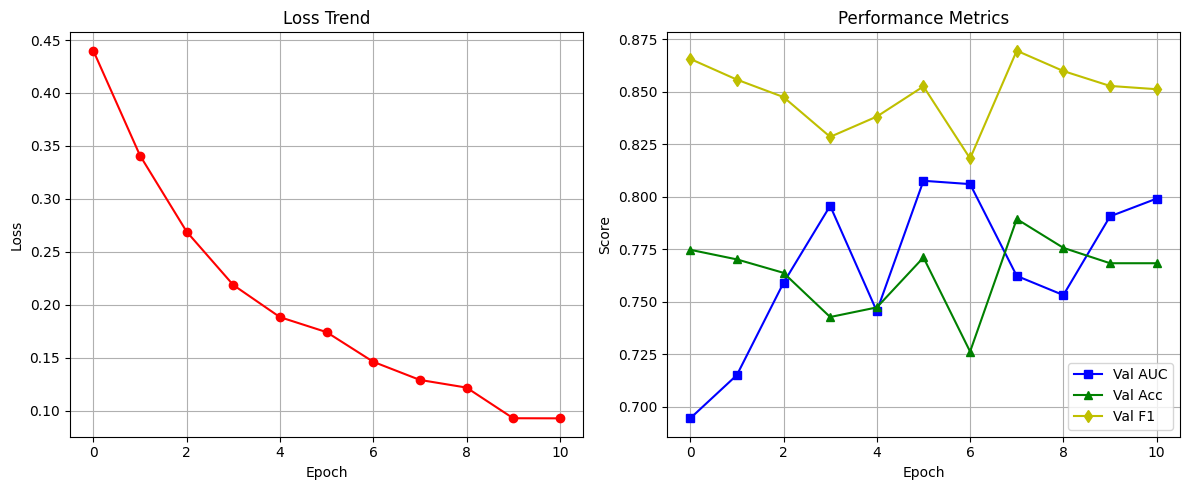

In [ ]:
# 5. 실행
history_dual_b4 = train_super_b4_dual(train_df, val_df, epochs=30, batch_size=4)
plot_history(history_dual_b4)

overfitting 의심되는 상황

1. Label Smoothing 적용: 정답을 1(진짜)과 0(가짜)으로 딱딱하게 주지 않고, 0.9와 0.1 정도로 부드럽게 주어 모델이 너무 확신하며 과적합되는 것을 방지

2. Weight Decay(가중치 감쇠) 상향: 모델의 파라미터가 너무 커지지 않게 규제를 강하게 걸어, 더 단순하고 명확한 특징에 집중하도록 함

3. Dropout 확률 증가: 현재 0.3인 Dropout을 0.5로 높여서, 모델의 일부 기능을 더 강제로 끄고 학습

4. FFT 스트림 비중 조절: 현재 B4(RGB)와 B0(FFT)가 합쳐질 때 RGB의 목소리가 너무 클 수 있음. 두 스트림의 가중치를 조절하거나, FFT 스트림에도 더 강력한 증강 넣어보기

In [ ]:
class DualStreamB4(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # RGB 스트림: EfficientNet-B4
        self.rgb_stream = timm.create_model('efficientnet_b4', pretrained=True, num_classes=0, global_pool='avg')
        # FFT 스트림: EfficientNet-B0
        self.fft_stream = timm.create_model('efficientnet_b0', pretrained=True, num_classes=0, global_pool='avg')

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(1792 + 1280, 512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(512, 1)
        )

    def forward(self, x_rgb, x_fft):
        feat_rgb = self.rgb_stream(x_rgb)
        feat_fft = self.fft_stream(x_fft)
        return self.classifier(torch.cat((feat_rgb, feat_fft), dim=1))

In [ ]:
def train_super_b4_dual_regularized(train_df, val_df, epochs=30, batch_size=4):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = DualStreamB4().to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)
    criterion = torch.nn.BCEWithLogitsLoss() # Label Smoothing은 아래 루프에서 수동 적용
    scaler = torch.amp.GradScaler('cuda')

    train_loader = DataLoader(DualStreamDataset(train_df, SAVE_IMG_DIR, train_transform),
                              batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(DualStreamDataset(val_df, SAVE_IMG_DIR, val_transform),
                            batch_size=batch_size, shuffle=False)

    history = {'train_loss': [], 'val_auc': [], 'val_acc': [], 'val_f1': []}
    best_auc, counter, patience = 0, 0, 5

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for imgs, ffts, labels in tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            imgs, ffts, labels = imgs.to(device), ffts.to(device), labels.to(device).unsqueeze(1)

            smoothed_labels = labels * (1 - 0.1) + 0.05

            optimizer.zero_grad()
            with torch.amp.autocast('cuda'):
                loss = criterion(model(imgs, ffts), smoothed_labels)

            scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
            total_loss += loss.item()

        model.eval()
        probs, targets = [], []
        with torch.no_grad():
            for imgs, ffts, labels in tqdm.tqdm(val_loader, desc="Val"):
                out = model(imgs.to(device), ffts.to(device))
                probs.extend(torch.sigmoid(out).cpu().numpy()); targets.extend(labels.numpy())

        probs, targets = np.array(probs).flatten(), np.array(targets).flatten()
        auc = roc_auc_score(targets, probs)
        acc = accuracy_score(targets, (probs > 0.5).astype(int))
        f1 = f1_score(targets, (probs > 0.5).astype(int))
        avg_loss = total_loss / len(train_loader)

        history['train_loss'].append(avg_loss)
        history['val_auc'].append(auc); history['val_acc'].append(acc); history['val_f1'].append(f1)
        scheduler.step(auc)

        print(f"✨ Epoch {epoch+1} - Loss: {avg_loss:.4f} | AUC: {auc:.4f} | Acc: {acc:.4f} | F1: {f1:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")

        if auc > best_auc:
            best_auc = auc; torch.save(model.state_dict(), "best_dual_b4_regularized.pth")
            print(f"🔥 모델 저장 완료 (AUC: {auc:.4f})"); counter = 0
        else:
            counter += 1
            if counter >= patience: print("🛑 Early Stopping!"); break

    return history

Val: 100%|██████████| 273/273 [00:19<00:00, 14.28it/s]


✨ Epoch 1 - Loss: 0.5011 | AUC: 0.6875 | Acc: 0.7445 | F1: 0.8414 | LR: 0.000100
🔥 모델 저장 완료 (AUC: 0.6875)


Val: 100%|██████████| 273/273 [00:19<00:00, 14.14it/s]


✨ Epoch 2 - Loss: 0.4268 | AUC: 0.8005 | Acc: 0.7280 | F1: 0.8161 | LR: 0.000100
🔥 모델 저장 완료 (AUC: 0.8005)


Val: 100%|██████████| 273/273 [00:19<00:00, 14.34it/s]


✨ Epoch 3 - Loss: 0.3902 | AUC: 0.7880 | Acc: 0.7106 | F1: 0.8020 | LR: 0.000100


Val: 100%|██████████| 273/273 [00:19<00:00, 14.22it/s]


✨ Epoch 4 - Loss: 0.3413 | AUC: 0.8307 | Acc: 0.7491 | F1: 0.8323 | LR: 0.000100
🔥 모델 저장 완료 (AUC: 0.8307)


Val: 100%|██████████| 273/273 [00:19<00:00, 14.24it/s]


✨ Epoch 5 - Loss: 0.3227 | AUC: 0.7817 | Acc: 0.7445 | F1: 0.8324 | LR: 0.000100


Val: 100%|██████████| 273/273 [00:19<00:00, 14.28it/s]


✨ Epoch 6 - Loss: 0.3083 | AUC: 0.8303 | Acc: 0.7967 | F1: 0.8706 | LR: 0.000100


Val: 100%|██████████| 273/273 [00:19<00:00, 14.29it/s]


✨ Epoch 7 - Loss: 0.2968 | AUC: 0.7706 | Acc: 0.7610 | F1: 0.8482 | LR: 0.000050


Val: 100%|██████████| 273/273 [00:19<00:00, 14.29it/s]


✨ Epoch 8 - Loss: 0.2723 | AUC: 0.7605 | Acc: 0.7720 | F1: 0.8548 | LR: 0.000050


Val: 100%|██████████| 273/273 [00:19<00:00, 14.21it/s]


✨ Epoch 9 - Loss: 0.2605 | AUC: 0.7969 | Acc: 0.7262 | F1: 0.8169 | LR: 0.000050
🛑 Early Stopping!


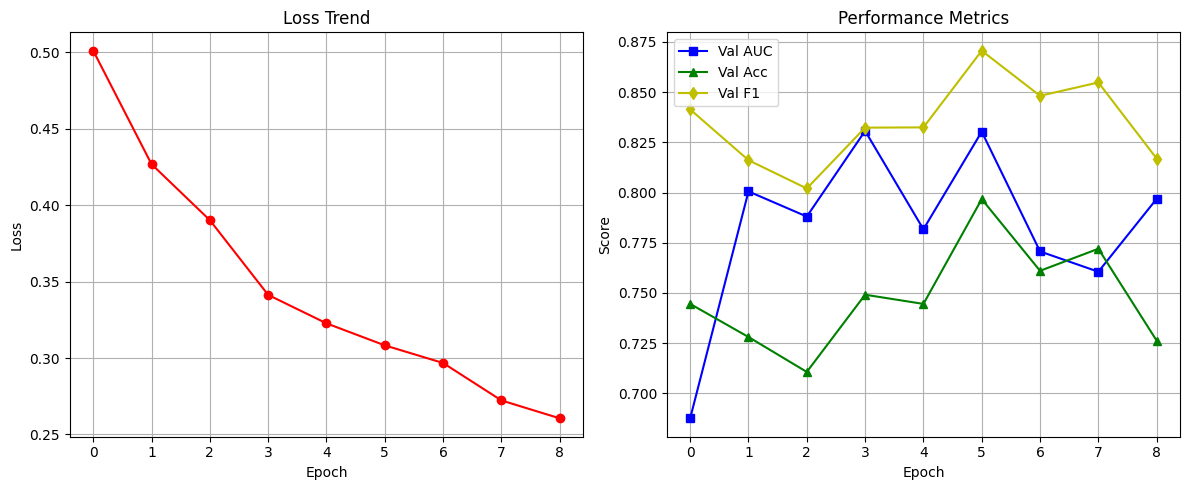

In [ ]:
history_dual_b4 = train_super_b4_dual_regularized(train_df, val_df, epochs=30, batch_size=4)
plot_history(history_dual_b4)

## 최종 버전

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import os
import tqdm
import pandas as pd
import numpy as np

# 경로 설정
TEST_DIR = "/content/drive/MyDrive/open/test_data"
TEST_ALIGNED_DIR = "/content/test_aligned_final"
os.makedirs(TEST_ALIGNED_DIR, exist_ok=True)

def preprocess_test_files(test_df, num_frames=5):
    print("🎯 테스트 데이터 프레임 추출 및 정렬을 시작합니다...")
    mapping_data = []

    for _, row in tqdm.tqdm(test_df.iterrows(), total=len(test_df)):
        filename = row['filename']
        path = os.path.join(TEST_DIR, filename)

        frames = []
        if filename.endswith('.mp4'):
            cap = cv2.VideoCapture(path)
            total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            # 균등 간격으로 프레임 추출
            for i in np.linspace(0, total - 1, num_frames, dtype=int):
                cap.set(cv2.CAP_PROP_POS_FRAMES, i)
                ret, frame = cap.read()
                if ret: frames.append(frame)
            cap.release()
        else:
            img = cv2.imread(path)
            if img is not None: frames.append(img)

        for i, frame in enumerate(frames):
            frame_name = f"{filename}_f{i}.jpg"
            save_path = os.path.join(TEST_ALIGNED_DIR, frame_name)

            try:
                rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                res = detector.detect(mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb))
                if res.face_landmarks:
                    l = res.face_landmarks[0]
                    h, w, _ = frame.shape
                    left = np.array([l[33].x * w, l[33].y * h])
                    right = np.array([l[263].x * w, l[263].y * h])
                    angle = np.degrees(np.arctan2(right[1]-left[1], right[0]-left[0]))
                    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
                    frame = cv2.warpAffine(frame, M, (w, h), flags=cv2.INTER_CUBIC)

                cv2.imwrite(save_path, cv2.resize(frame, (380, 380)))
                mapping_data.append({'filename': filename, 'frame_file': frame_name})
            except:
                cv2.imwrite(save_path, cv2.resize(frame, (380, 380)))
                mapping_data.append({'filename': filename, 'frame_file': frame_name})

    return pd.DataFrame(mapping_data)

test_df = pd.read_csv("/content/drive/MyDrive/open/sample_submission.csv")
mapping_df = preprocess_test_files(test_df)

🎯 테스트 데이터 프레임 추출 및 정렬을 시작합니다...


100%|██████████| 500/500 [00:14<00:00, 35.36it/s] 


In [ ]:
# 1. 컬럼명 확인
print("📊 test_df 컬럼 목록:", test_df.columns)

# 2. 첫 번째 파일 경로 확인
first_file = test_df.iloc[0]['filename'] # 만약 에러 나면 컬럼명이 filename이 아닌 것임
full_path = os.path.join(TEST_DIR, first_file)
print(f"📁 확인 중인 경로: {full_path}")
print(f"✅ 파일 존재 여부: {os.path.exists(full_path)}")

📊 test_df 컬럼 목록: Index(['filename', 'prob'], dtype='object')
📁 확인 중인 경로: /content/drive/MyDrive/open/test_data/TEST_000.mp4
✅ 파일 존재 여부: True


In [ ]:
# 1. 전처리 함수 실행 (mapping_df를 새로 생성)
# num_frames를 5정도로 설정하면 적당합니다.
mapping_df = preprocess_test_files(test_df, num_frames=5)

# 제대로 만들어졌는지 확인 (반드시 filename, frame_file이 있어야 함!)
print("✅ 확인된 컬럼:", mapping_df.columns)
# 결과가 Index(['filename', 'frame_file'], dtype='object') 로 나와야 합니다.

🎯 테스트 데이터 프레임 추출 및 정렬을 시작합니다...


100%|██████████| 500/500 [00:02<00:00, 211.04it/s]

✅ 확인된 컬럼: Index(['filename', 'frame_file'], dtype='object')


In [ ]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset

class OfflineDualStreamDataset(Dataset):
    def __init__(self, df, aligned_dir, transform=None):
        """
        df: 파일명이 포함된 데이터프레임
        aligned_dir: 얼굴 정렬이 완료된 이미지 저장 경로
        transform: Albumentations 증강 설정
        """
        self.df = df
        self.aligned_dir = aligned_dir
        self.transform = transform

    def get_fft(self, img):
        """이미지에서 주파수 영역의 격자 노이즈(Artifacts)를 추출합니다."""
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        f = np.fft.fft2(gray)
        fshift = np.fft.fftshift(f)
        mag = 20 * np.log(np.abs(fshift) + 1)
        mag = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
        return cv2.merge([mag, mag, mag]).astype(np.uint8)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.aligned_dir, row['file_name'])
        image = cv2.imread(img_path)

        if image is None:
            image = np.zeros((380, 380, 3), dtype=np.uint8) # B4 기본 사이즈

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        fft_image = self.get_fft(image)

        if self.transform:
            augmented = self.transform(image=image, fft_image=fft_image)
            image, fft_image = augmented['image'], augmented['fft_image']

        label = row.get('label', 0)
        return image, fft_image, torch.tensor(label, dtype=torch.float32)

    def __len__(self):
        return len(self.df)

In [ ]:
def generate_final_submission(mapping_df, submission_df, model_path="best_dual_b4_regularized.pth"):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 1. 모델 로드 (과적합 방지가 적용된 최신 모델)
    model = DualStreamB4().to(device)
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path))
        print(f"✅ 모델 가중치 로드 완료: {model_path}")
    model.eval()

    # 2. Dataset용 임시 데이터프레임 생성 (KeyError 방지)
    # Dataset은 'file_name' 컬럼을 기대하므로 frame_file을 복사해서 이름을 바꿉니다.
    inference_df = mapping_df.copy()
    inference_df['file_name'] = inference_df['frame_file']

    dataset = OfflineDualStreamDataset(inference_df, TEST_ALIGNED_DIR, val_transform)
    loader = DataLoader(dataset, batch_size=8, shuffle=False, num_workers=2)

    frame_probs = []
    print("🧪 프레임별 독립 추론 중... (0.95 AUC를 향해!)")
    with torch.no_grad():
        for imgs, ffts, _ in tqdm.tqdm(loader):
            imgs, ffts = imgs.to(device), ffts.to(device)
            with torch.amp.autocast('cuda'):
                out = model(imgs, ffts)
            frame_probs.extend(torch.sigmoid(out).cpu().numpy().flatten())

    # 3. 결과 종합 (후처리: 프레임 확률 평균내기)
    mapping_df['frame_prob'] = frame_probs

    # 원본 filename 별로 평균 계산
    final_results = mapping_df.groupby('filename')['frame_prob'].mean().reset_index()

    # 4. 제출 양식(submission_df)과 결합
    # submission_df에 원래 있던 prob 컬럼은 제거하고 예측값으로 채웁니다.
    if 'prob' in submission_df.columns:
        submission_df = submission_df.drop(columns=['prob'])

    submission_df = submission_df.merge(final_results, on='filename', how='left')
    submission_df.rename(columns={'frame_prob': 'prob'}, inplace=True)

    # 혹시라도 얼굴 탐지에 실패하여 확률이 없는 경우 0.5(중립)로 채움
    submission_df['prob'] = submission_df['prob'].fillna(0.5)

    # 최종 파일 저장
    submission_df.to_csv("final_submission.csv", index=False)
    print("✨ 'final_submission.csv' 생성이 완료되었습니다! 이제 제출하세요!")

# 실행!
generate_final_submission(mapping_df, test_df)

✅ 모델 가중치 로드 완료: best_dual_b4_regularized.pth
🧪 프레임별 독립 추론 중... (0.95 AUC를 향해!)


100%|██████████| 6/6 [00:17<00:00,  2.86s/it]

✨ 'final_submission.csv' 생성이 완료되었습니다! 이제 제출하세요!
